# Wildfire Impact on Redmond, OR
---
The goal of this work is to explore the impact of wildfires on Redmond, Oregon. Specifically, we will be looking at the wildfire prevalence & air quality as a way to measure the smoke impacts over the past 60 years.

A cleaned, collated data of wildfire location and prevalence was generated by the US Geological Survey.

## License

Note that some portions of the following code was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code was provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.0 - August 13, 2023.

Specifically, the following functions were intially written by Dr. McDonald and modified by me:
* `convert_ring_to_epsg4326()`
* `shortest_distance_from_place_to_fire_perimeter()`

The rest of the code lies under the standard [MIT licence](./LICENSE).

## 0. Set-up
---
This notebooks assumes that the user has a working Jupyter Notebook Python 3 set-up. Instructions on installing them can be found [here](https://docs.jupyter.org/en/latest/install/notebook-classic.html).

Specifically, here are the following Python modules that we need for this work. Some are standard modules that come installed with Python and others should come installed as part of the [Anaconda](https://docs.jupyter.org/en/latest/install/notebook-classic.html) distribution. 

If modules are not found, they can be readily installed with the following terminal commands:

```bash
    pip install <module name>
```
or 
```bash
   conda install <module name>
```

The notebook has dependencies on [pyproj](https://pyproj4.github.io/pyproj/stable/index.html) and the [geojson](https://pypi.org/project/geojson/) libraries.

In [2]:
# These are standard python modules
import json, copy

# The 'geojson', 'pyproj', 'tqdm', and 'pandas' modules 
# are not standard python libraries
# You will need to install these with pip/pip3 if you do not already have it

# a highly recommended progress bar for loops.
from tqdm.auto import tqdm, trange
# a recommended module to read and wrangle data
import pandas as pd
# recommended modules for visualization
import matplotlib.pyplot as plt
import seaborn as sns

#  provides tools to convert between different geodesic coordinate systems
#  and for calculating distances between points (coordinates) in a specific geodesic system.
from pyproj import Transformer, Geod

# a JSON wrapper to do some conversion of Geo-type things in GeoJSON files
import geojson

# Best for array manipulation and stats
import numpy as np
import scipy as sp

# more specialized polygon manipulation functions
from shapely.geometry import Polygon, Point
from shapely.ops import nearest_points

## 1. Wildfire Data
---

### Data Loading
Data of US wildfires was collected and aggregated by the US Geological Survey as the [Combined wildland fire datasets for the United States and certain territories, 1800s-Present (combined wildland fire polygons](https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81) dataset. 

For this project, we will use the GeoJSON data format stored under `GeoJSON Files.zip`. This folder contains both a raw merged dataset containing duplicates and a "combined", duplicate-free, dataset that comprises both wildfires and prescribed fires from mid 1800s to the 2021 collated from 40 different original wildfire datasets. For our analysis, we will use only the combined data stored at [./input/USGS_Wildland_Fire_Combined_Dataset.json](./input/USGS_Wildland_Fire_Combined_Dataset.json).


In [2]:
%%time
# file path
WILDFIRE_GEOJSON_PTH = './input/USGS_Wildland_Fire_Combined_Dataset.json'
# load data using geojson's load function which requires opening the file
with open(WILDFIRE_GEOJSON_PTH, 'r') as file:
    geo_data = geojson.load(file)

Wall time: 1min 41s


In [3]:
print(f"There are {len(geo_data['fields'])} fields (# of attributes per observation).")
print(f"There are {len(geo_data['features'])} features (# of observations).")
print(f"The header has the following keys:\n{list(geo_data.keys())}")

There are 30 fields (# of attributes per observation).
There are 135061 features (# of observations).
The header has the following keys:
['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features']


Note that much of this data was originally generated from an ArcGIS server and shares a lot of variable names. It's also the reason the default geometry type is `esriGeometryPolygon` -- Esri is the developer of ArcGIS.

#### Keys:
* `displayFieldName`: empty string that would otherwise denote the name of the dataset.
* `fieldAliases`: dictionary converts between the variable name in the file to a more human-readable format for the 30 fields.
* `geometryType`: esriGeometryPolygon is the default geometry format.
* [`spatialReference`](https://developers.arcgis.com/web-map-specification/objects/spatialReference/): the well-known ID (WKID) of the spatial reference (as well as the latest WKID). This data uses  [102008](https://epsg.io/102008), which refers to the Albers equal-area map projection of North America.
* `fields`: A list of dicts identifying the `name`, `type` and `alias` of 30 attributes. The `alias` is the same as those in `fieldAliases`. Also, the `types` are based on the [Esri specifications](https://developers.arcgis.com/web-map-specification/objects/field/). A full, detailed explanation of each of the attributes can be found [here](./input/Wildland_Fire_Polygon_Metadata.xml).
* `features`: the list of all observations stored in JSON format. Note that each observation is saved as dictionary with keys for the `attributes` (same as those in `fields`) and `geometry`, which contains sets of tuples denoting the coordinate points of the wildfire polygon in the WKID projection space. In the case of this data, most wildfires are polygons represented by ['rings'](https://developers.arcgis.com/documentation/common-data-types/geometry-objects.htm#:~:text=%7B%0A%20%20%22paths%22%3A%20%5B%20%5D%0A%7D-,Polygon,-A%20polygon%20(specified) in ArcGIS. 


A ring is a list of points denoting the path of the ring. The exterior ring of a polygon is denoted by a list of points oriented clockwise while internal rings are points oriented in a counterclockwise motion. The `rings` key for `geometry` has multiple poylgons decreasing in area. The first 'ring' denotes the largest boundary of the fire. Subsequent rings follow an even-odd fill rule (first fills, 2nd removes, etc).


The expected attributes for each observation are as follows:

In [4]:
list(geo_data['features'][0]['attributes'].keys())

['OBJECTID',
 'USGS_Assigned_ID',
 'Assigned_Fire_Type',
 'Fire_Year',
 'Fire_Polygon_Tier',
 'Fire_Attribute_Tiers',
 'GIS_Acres',
 'GIS_Hectares',
 'Source_Datasets',
 'Listed_Fire_Types',
 'Listed_Fire_Names',
 'Listed_Fire_Codes',
 'Listed_Fire_IDs',
 'Listed_Fire_IRWIN_IDs',
 'Listed_Fire_Dates',
 'Listed_Fire_Causes',
 'Listed_Fire_Cause_Class',
 'Listed_Rx_Reported_Acres',
 'Listed_Map_Digitize_Methods',
 'Listed_Notes',
 'Processing_Notes',
 'Wildfire_Notice',
 'Prescribed_Burn_Notice',
 'Wildfire_and_Rx_Flag',
 'Overlap_Within_1_or_2_Flag',
 'Circleness_Scale',
 'Circle_Flag',
 'Exclude_From_Summary_Rasters',
 'Shape_Length',
 'Shape_Area']

Extract the WKID:

In [5]:
# Projection ID of the dataset:
DATA_WKID = geo_data['spatialReference']['wkid']

# fields
DATA_FIELDS = geo_data['fields']

Now, let's convert the dict of feature dicts into a DataFrame. We do this using Pandas's [`pd.json_normalize()`](https://pandas.pydata.org/docs/reference/api/pandas.json_normalize.html). This allows us to flattens nesting dictionaries of each observation into one DataFrame.

In [6]:
%%time
# flatten dict of dicts into DataFrame
geo_df = pd.json_normalize(geo_data['features'])
# remove prefixes of column names
geo_df.columns = [col.split(".")[-1] for col in geo_df.columns]
# peek at the data
geo_df.head()

Wall time: 5.79 s


,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Prescribed_Burn_Notice,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,rings,curveRings
0,1,1,Wildfire,1860,1,1 (1),3940.207089,1594.545237,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),...,Prescribed fire data in this dataset represent...,None,None,0.047590,NaN,No,64888.449849,1.594545e+07,"[[[-1883775.5960000008, 1194154.1922999993], [...",NaN
1,2,2,Wildfire,1860,1,1 (1),772.518249,312.627044,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),...,Prescribed fire data in this dataset represent...,None,None,0.071367,NaN,No,23462.288613,3.126270e+06,"[[[-1887470.1312000006, 1187759.2441000007], [...",NaN
2,3,3,Wildfire,1860,1,1 (1),333.020409,134.768578,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),...,Prescribed fire data in this dataset represent...,None,None,0.379578,NaN,No,6679.573569,1.347686e+06,"[[[-1889386.1190000009, 1190683.9283000007], [...",NaN
3,4,4,Wildfire,1870,1,"1 (1), 3 (1)",22294.993577,9022.463795,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (1)",...,Prescribed fire data in this dataset represent...,None,None,0.158038,NaN,No,84700.719226,9.022464e+07,"[[[-1428896.2971, 864980.0340999998], [-142869...",NaN
4,5,5,Wildfire,1870,1,"1 (1), 3 (1)",36.985574,14.967531,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (1)",...,Prescribed fire data in this dataset represent...,None,None,0.218009,NaN,No,2937.265383,1.496753e+05,"[[[-1371410.4136999995, 595942.3960999995], [-...",NaN


Unexpectedly, we notice an extra column for `curveRings`. Let's check when this occurs:

In [8]:
geo_df.isna().sum()

OBJECTID                             0
USGS_Assigned_ID                     0
Assigned_Fire_Type                   0
Fire_Year                            0
Fire_Polygon_Tier                    0
Fire_Attribute_Tiers                 0
GIS_Acres                            0
GIS_Hectares                         0
Source_Datasets                      0
Listed_Fire_Types                    0
Listed_Fire_Names                    0
Listed_Fire_Codes                    0
Listed_Fire_IDs                    851
Listed_Fire_IRWIN_IDs            36564
Listed_Fire_Dates                  307
Listed_Fire_Causes                   0
Listed_Fire_Cause_Class              0
Listed_Rx_Reported_Acres        110020
Listed_Map_Digitize_Methods      13458
Listed_Notes                     35685
Processing_Notes                 33072
Wildfire_Notice                      0
Prescribed_Burn_Notice               0
Wildfire_and_Rx_Flag            133216
Overlap_Within_1_or_2_Flag      118085
Circleness_Scale         

Let's select a subset of features we're interested in:

In [13]:
FEATURE_SUBSET = [
    'OBJECTID',
#     'USGS_Assigned_ID',
    'Assigned_Fire_Type',
    'Fire_Year',
#     'Fire_Polygon_Tier',
#     'Fire_Attribute_Tiers',
    'GIS_Acres',
    'GIS_Hectares',
#     'Source_Datasets',
#     'Listed_Fire_Types',
    'Listed_Fire_Names',
#     'Listed_Fire_Codes',
#     'Listed_Fire_IDs',
#     'Listed_Fire_IRWIN_IDs',
#     'Listed_Fire_Dates',
#     'Listed_Fire_Causes',
#     'Listed_Fire_Cause_Class',
#     'Listed_Rx_Reported_Acres',
#     'Listed_Map_Digitize_Methods',
#     'Listed_Notes',
#     'Processing_Notes',
#     'Wildfire_Notice',
#     'Prescribed_Burn_Notice',
#     'Wildfire_and_Rx_Flag',
#     'Overlap_Within_1_or_2_Flag',
#     'Circleness_Scale',
#     'Circle_Flag',
#     'Exclude_From_Summary_Rasters',
    'Shape_Length',
    'Shape_Area',
    'rings',
    'curveRings'
]
geo_df = geo_df[FEATURE_SUBSET]

In [14]:
# filter where curveRings is Null to see if it matches the
# number of nulls for rings.
curveRings_tmp = geo_df[~geo_df['curveRings'].isna()]
curveRings_tmp

,OBJECTID,Assigned_Fire_Type,Fire_Year,GIS_Acres,GIS_Hectares,Listed_Fire_Names,Shape_Length,Shape_Area,rings,curveRings
109604,109605,Prescribed Fire,2007,1216.321596,492.227886,BARNES SOUTH UNDERBURN - BARNES SOUTH UNDERBU...,1.596184e+04,4.922279e+06,NaN,"[[[-1933812.9145, -110739.56220000051], [-1933..."
110223,110224,Prescribed Fire,2007,52.076772,21.074722,BOYD JOHNSON (1),2.125347e+03,2.107472e+05,NaN,"[[[974392.1541999988, -534800.9936999995], [97..."
110638,110639,Prescribed Fire,2008,1761.856058,712.997850,"VIRGINIAS (3), 10S18 UNDERBURN UNIT 5 (1)",2.553059e+04,7.129979e+06,NaN,"[[[-1934912.9165000003, -107322.49349999987], ..."
111430,111431,Prescribed Fire,2008,110.630405,44.770537,"GEORGE BRAND (1), LISA VAUGHN (1), ANDREW WILK...",4.067479e+03,4.477054e+05,NaN,"[[[1124302.3839999996, -656249.7921999991], {'..."
111775,111776,Prescribed Fire,2009,5076.551841,2054.407642,"HOMOCHITTO BURN BLOCK 36 (1), HOMOCHITTO BURN ...",4.023018e+04,2.054408e+07,NaN,"[[[437642.4063999988, -1010131.8737000003], [4..."
111896,111897,Prescribed Fire,2009,1328.229087,537.515241,VIRGINIAS (2),1.606763e+04,5.375152e+06,NaN,"[[[-1936451.6747999992, -107721.65520000085], ..."
112409,112410,Prescribed Fire,2009,171.272003,69.311320,JAMIE JORDON (1),2.957448e+03,6.931132e+05,NaN,"[[[948556.4836000018, -604134.5874000005], [94..."
112414,112415,Prescribed Fire,2009,232.111047,93.932008,"JIM TIMBERLAKE (1), CHUCK WILLIAMS (1), ANARAS...",5.460628e+03,9.393201e+05,NaN,"[[[1114198.0859000012, -660838.9208000004], [1..."
113410,113411,Prescribed Fire,2010,422.843583,171.118727,No Fire Name Provided (1),6.093900e+03,1.711187e+06,NaN,"[[[1187648.7747999988, -614779.3047000002], [1..."
113664,113665,Prescribed Fire,2010,165.004515,66.774958,WILLIAM GHOLSTON (1),2.904082e+03,6.677496e+05,NaN,"[[[1039463.3993999995, -568889.7269000001], [1..."


It looks like the `curveRings` only has a value when `rings` is empty. According to [ArcGIS documentation](https://developers.arcgis.com/documentation/common-data-types/geometry-objects.htm#:~:text=y%5D%2C%20%5Bx%2C%20y%5D%5D%7D-,Polyline%20with%20curves,-A%20polyline%20with), it seems that unlike `rings`, `curveRings` are not just a simple list of points denoting the shape. Instead they can be much more complex. However, it might be possible that the authors of the dataset converted these `curveRings` back to normal `rings`. So, let's verify that the data format matches that of the `rings`:
* list of tuples that have 2 elements. 
* No additional dictionaries in the polygon.

In [16]:
# iterate through all observations
for obs in range(len(curveRings_tmp)):
    # iterate through all rings of polygon
    for numRings in range(len(curveRings_tmp['curveRings'].iloc[obs])):
        # iterate through all x-y tuples
        for rTuple in curveRings_tmp['curveRings'].iloc[obs][numRings]:
            try:    
                # check that its the expected format
                assert len(rTuple) == 2
            except:
                # print out "tuple" and go to the next observation
                print(f"observation {obs}: {rTuple}")
                break

observation 0: {'b': [[-1934810.4616, -113974.30440000072], [-1934810.232777732, -113974.94540095767], [-1934810.3467498617, -113974.62480163362]]}
observation 1: {'a': [[974784.2747999988, -535023.4684999995], [974518.94400624, -534944.1499077352], 1, 1, 0.26414981448430086, 294.5409787205969, 0.8239217910548937]}
observation 2: {'b': [[-1936530.730799999, -111021.21910000034], [-1936528.0956672975, -111023.11868082457], [-1936529.4212850693, -111022.18665438081]]}
observation 2: {'b': [[-1935812.0864000004, -108103.8032000009], [-1935811.2730469992, -108105.79584851682], [-1935811.6919756306, -108104.80949255572]]}
observation 3: {'a': [[1124268.9450999983, -655927.6524999999], [1124342.150340564, -656082.1367563709], 1, 1, 0.13739895298126142, 212.07735369676428, 0.7924321696529887]}
observation 4: {'a': [[444052.44900000095, -1007032.1886], [444645.2031211794, -1006816.7131056463], 1, 0, 6.264204183951433, 645.4730056712403, 0.8553603025361982]}
observation 5: {'b': [[-1936384.4649

As it turns out, the authors did not preprocess this into one format. We clearly see the other formats listed [here](https://developers.arcgis.com/documentation/common-data-types/geometry-objects.htm#:~:text=%7B%0A%20%20%22rings%22%3A%20%5B%20%5D%0A%7D-,JSON%20curve%20object,-At%2010.3%2C%20a)

As such, we will need to consolidate that ourselves for those observations should we need it.

The consolidation process involves constructing polygons & densifying it by approximating the curved segments as points. Unfortunately, this can only be done simply using the ArcGIS software, which now requires a subscription. As such for the time being, we will pray we don't need those 35 observations. If not, we will only access specific points in the fire perimeter ring and ignore all other curve segments.

In [10]:
# pyproj.CRS.from_string("EPSG:4326")
# pyproj.CRS.from_string("ESRI:102008")

### Filtering Data
For our analysis, we're only interested in a select subset of wildfires satisfying two main criteria:
1. Fires from 1963 onwards (1963 inclusive).
2. Fires within 1250 miles of Redmond, Oregon. 

The first is easy enough to filter. We do this to avoid potentially bad data estimated prior to the advent of the satelitte imaging.

The second requires a couple of assumptions.
* We mark 44.272621, -121.173920 as the latitude & longitude coordinates as the center of the city. [Source](https://latitude.to/map/us/united-states/cities/redmond-oregon)
* We denote "within 1250 miles" to mean fires whose closest boundary point has a total straight-line ellipsoid distance less than 1250 miles to the center of the city.

To calculate distance, we must convert the projection of the ring data from the current  equal-area Albers projection ([`ESRI:102008`](https://epsg.io/102008)) to a more accurate, WGS84, decimal-degrees representation better for distance calculations ([`EPSG:4326`](https://epsg.io/4326)).

We will use the first ring to denote the perimeter of a fire (the largest boundary) and convert all the points to the new WGS84 projection to calculate the distance relative to the lat-lon coordinates of the city using `Pyproj` and the WGS84 ellipsoid geodesic model of the earth. 

In [17]:
# filter based on < 1250 miles
CLOSEST_MILEAGE_BOUNDARY = 1250 
# city lat-lon coordinates
CITY = 'Redmond, OR'
CITY_LAT_LON = (44.272621, -121.173920)

Let's filter on year first using the `Fire_Year` attribute:

In [18]:
# check that we have no missing values for year:
assert geo_df['Fire_Year'].isna().sum() == 0
# filter by year
filter_df = geo_df[geo_df['Fire_Year'] >= 1963].copy()
# We notice that missing rings are still present
filter_df['rings'].isna().sum()

35

We see that the curveRings are still in the data set -- alas our prayers weren't answered. Let's gather the first ring from either set and concatenate into a single column:

In [24]:
# Extract only first ring (fire perimeter) from rings
filter_df['ring'] = filter_df['rings'].apply(lambda x: x[0] if x is not np.NaN else None)
# gather first of curve rings
curve_Rings = curveRings_tmp['curveRings'].apply(lambda x: x[0])
# excise out the curved segments.
for index in tqdm(curve_Rings.index):
    newlist = []
    # check that its a value x,y coord
    for val in curve_Rings.loc[index]:
        if len(val) ==2:
            newlist.append(val)
    # make new list at the index
    filter_df.at[index, 'ring'] = newlist
# remove extra rings
filter_df.drop(columns = ['rings', 'curveRings'], inplace=True)

In [116]:
filter_df.isna().sum()

OBJECTID              0
Assigned_Fire_Type    0
Fire_Year             0
GIS_Acres             0
GIS_Hectares          0
Listed_Fire_Names     0
Shape_Length          0
Shape_Area            0
ring                  0
dtype: int64

Let's define some functions to help calculate distances.

In [121]:
# Create a transformer that converts from ESRI:102008 to EPSG:4326
# define this outside to maximize efficiency yields:
# https://pyproj4.github.io/pyproj/stable/advanced_examples.html#advanced-examples
to_epsg4326 = Transformer.from_crs(f"ESRI:{DATA_WKID}", "EPSG:4326")
def convert_ring_to_epsg4326(ring_data=None,
                             to_epsg4326=to_epsg4326, 
                             return_xy=False):
    """
    Transform feature geometry data from one project to another.
    The default transforms from ESRI:102008 to EPSG:4326.
    
    Note: CRS -- coordinate reference system
    Parameters:
        ring_data (list of tuples): A list of  coordinates to be transformed.
        to_epsg (object): Pyproj Transformer for more efficient projections

        return_xy (bool): returns in lon-lat if True, lat-lon else.
    Returns:
        list of tuples: A list of coordinates in new projection space. 
                        Default is decimal degree lat, lon for EPSG:4326.
    """
    converted_ring = list()
    try:
        # Convert the ring_data to a NumPy array for vectorized operations
        ring_data_array = np.array(ring_data)
        # Use NumPy vectorized operations to transform the coordinates
        latitudes, longitudes = to_epsg4326.transform(ring_data_array[:, 0], ring_data_array[:, 1])
        # Create a list of tuples from the transformed NumPy arrays
        if return_xy:
            return list(zip(longitudes, latitudes))
        converted_ring = list(zip(latitudes, longitudes))
    except:
        # Iterate through the list, transforming each input x,y coordinate into decimal degree lat, lon
        for coord in ring_data:
            lat, lon = to_epsg4326.transform(coord[0], coord[1])
            new_coord = lon, lat if return_xy else lat, lon
            converted_ring.append(new_coord)
    return converted_ring


def shortest_distance_from_place_to_fire_perimeter(place=None, 
                                                   ring_data=None):
    """
    Calculate the shortest distance from a given place to a fire perimeter.

    Parameters:
        place (tuple or list): A coordinate point (latitude, longitude) in decimal degrees (EPSG:4326).
        ring_data (list): A list of decimal degree coordinates representing the fire boundary.
    Returns:
        The shortest distance to the perimeter

    This function takes a specific location (place) and a list of coordinates representing a 
    fire boundary (ring_data). It calculates the shortest distance from the given place to
    any point on the fire perimeter and returns a list containing the shortest distance 
    in miles and the corresponding point on the perimeter.
    """
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data, return_xy=True)    
    
    # generate a poly & check if point is inside it then return 0
    try:
        polygon = Polygon(ring)
        point = Point(place[1], place[0])
        if polygon.contains(point):
            return 0
    except:
        print("Unable to generate polygon.")

    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')    
    min_dist = np.inf
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        # function requires lon, lat instead of lat-lon
        d = geodcalc.inv(place[1],place[0],point[0],point[1])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        min_dist = min(distance_in_miles, min_dist)
    return min_dist

Now, let's apply the function on all values.

In [58]:
ring = convert_ring_to_epsg4326(ring_data=geo_df['rings'][0][0], return_xy=True)    
polygon = Polygon(ring)
point = Point(CITY_LAT_LON[1], CITY_LAT_LON[0])

In [122]:
%%time
# track minimum distance to city
min_distance_to_city = []
for perimeter in tqdm(filter_df['ring'].to_list()):
#     if fire_rings is not np.NaN:
    if perimeter:    
        min_distance = shortest_distance_from_place_to_fire_perimeter(
            place=CITY_LAT_LON,
            ring_data=perimeter)
    else:
        min_distance = -1
    min_distance_to_city.append(min_distance)

# add this to the dataframe
filter_df['min_distance_city'] = min_distance_to_city

  0%|          | 0/117578 [00:00<?, ?it/s]

Unable to generate polygon.
Wall time: 5min


In [125]:
len(min_distance_to_city)

117578

### Storing Local Copy of Desired Subset

In [131]:
redmond_subset = filter_df[filter_df['min_distance_city'] <= 1250]
redmond_subset.to_csv('./intermediate/redmond_fire_subset.csv')

## 2. Smoke Estimate
---

Our goal is to create an annual estimate of wildfire smoke in Redmond, OR to better understand the impact of wildfires on residents inside the city. Throughout the project, we will consider other socio-economic impacts as well. For this section, we'll only attempt to estimate the smoke seen by the city during each annual fire season using the given data while recognizing its limitations.

Typically, smoke is dependent on wind patterns over several days, the intensity of the fire, its duration, and the distance from the city. However, for the sake of this assignment, we only have access to the fire area & distance. Additionally, we can distinguish between the type of fire as a proxy for fire intensity: prescribed fires and true wildfires.

Prescribed burns are conducted on days where weather conditions are optimal as a way to mitigate safety risks and the spread of smoke. [\[1\]](https://extension.okstate.edu/fact-sheets/the-best-time-of-year-to-conduct-prescribed-burns.html) As such, prescribed fires can be assumed to contribute less to the smoke drifting over nearby cities than wildfires. 

We also know that larger fires near the city will contribute more to smoke quantity over a city than small fires further away. However, how much do we estimate each factor, area & distance, to contribute to the overall quantity? 

Smoke is generated from incomplete combustion, denoted by the formula, $\text{Fuel} + O_2 \rightarrow CO_2 + H_2O + \text{byproducts}$.[\[2\]](https://www.sciencelearn.org.nz/resources/748-what-is-smoke) This tells us that smoke is linearly proportional to the amount of fuel burned, which in turn is linearly proportional to the area burned. 

Meanwhile, the intensity of energy, force, or flux evenly radiated from a source follows an inverse-square law with distance as commonly observed with light.[\[3\]](https://en.wikipedia.org/wiki/Inverse-square_law) We can model smoke as flux originating from the fire and evenly radiating outward from the burned area. So, the smoke estimate of the city can be an inverse square of the distance between the city and the fire. Putting the above assumptions together yields our initial estimate for smoke from a single fire:

$$\text{smoke} \propto \frac{\text{area}}{\text{distance}^2}$$

However, we know that the type of fire drastically changes its dispersal over a city. We can model this as a varying baseline for each fire type:
$$\text{smoke} \propto \frac{\text{area}}{\text{distance}^2} + \text{fire type}$$

<!-- or as an interaction term with the fire dispersal $\frac{\text{area}}{\text{distance}^2}$:

$$\text{smoke} \propto \frac{\text{area}}{\text{distance}^2} + \text{fire type} + \frac{\text{area}}{\text{distance}^2}$$
 -->

Let $s$ be the smoke, $a$ be the area, $d$ be the distance, and $t$ be the fire type. Then, the proportional relation results in the following equation:
$$s = \beta_0 + \beta_1 \frac{a}{d^2} + \beta_2 t,$$ 
where $\beta$ is a tunable set of weights. Note that $\beta_0$ is the baseline amount of smoke present not attributed to wildfires, $\beta_1$ is the tunable fire-dispersal weight, and $\beta_2$ articulates the difference in baselines between different fire types. Ideally, if we know the levels of the known quantity we aim to model, we can tune the weights further. For now, let's use the following simple values for $\beta$:
* $\beta_0 = 0$
* $\beta_1 = 1$
* $\beta_2 = 1$

In the context of our data set, we'll define `GIS_Acre` as our area variable, `min_distance_city` as the distance variable, and `Assigned_Fire_Type` as the fire type variable.
* `GIS_Acres` is numeric and has units of acres.
* `min_distance_city` is numeric and has units of miles.
* `Assigned_Fire_Type` is a categorical variable with values ranging from `Wildfire` to `Prescribed Fire`. Let's numerically rank this from a baseline of `Prescribed Fire` to a maximum of `Wildfire` to ordinally encode $t$ with $\beta_2$ amount of separation between each fire level, thereby adjusting for different baseline contributions of each fire type. 
    * 'Wildfire': 5
    * 'Likely Wildfire': 4
    * 'Unknown - Likely Wildfire': 3
    * 'Unknown - Likely Prescribed Fire': 2 
    * 'Prescribed Fire': 1
    
*Note that while area and distance might have different imperial units, we can ignore the conversion as this is something that can be tuned with $\beta$.*

In [5]:
# let's load the data from the stored intermediate copy
redmond_subset = pd.read_csv('./intermediate/redmond_fire_subset.csv', index_col=0)

Let's define the functions using the above equation below.

In [41]:
def calculate_smoke_estimate(observation, betas=[0,1,1]):
    """
    Using custom definition to calculate smoke estimate contribution per fire.
    
    Note, we designate area by 'GIS_Acre', distance with 'min_distance_city',
    and fire type with 'Assigned_Fire_Type'
    Parameters:
        observation (dict/row): a set of attributes for a single fire observation.
        betas (list): a list of floats denoting the weights of the variables
    Return:
        float, for the estimate smoke from a single fire.
    """
    
    # area, distance, type
    a = observation['GIS_Acres']
    d = observation['min_distance_city']
    t = observation['Assigned_Fire_Type']
    
    # ordinal encoding of t:
    ordinal_map = {
        'Wildfire': 5,
        'Likely Wildfire': 4,
        'Unknown - Likely Wildfire': 3,
        'Unknown - Likely Prescribed Fire': 2,
        'Prescribed Fire': 1
    }
    t = ordinal_map[t]
    
    # apply equation
    s = betas[0] + (betas[1]*(a/(d**2)))+ (betas[2]*t)
    
    return s
    

Let's apply the function to our data usings Pandas [`pd.apply()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) function.


In [ ]:
redmond_subset['smoke_estimates'] = redmond_subset.apply(
    lambda x: calculate_smoke_estimate(x), axis=1)

Let's check that the output actually makes sense:

As we see from the log-hist plot, the smoke estimate has a long-tail distribution with a large portion of them having little effect and only about 100 above contributions of 10 and 10 above 50. This is about what we would expect.  

Text(0.5, 1.0, 'Smoke Contribution of Individual Fires')

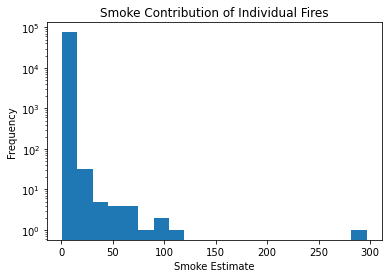

In [76]:
# plot histogram and make y-axis log-scale for better visibility.
_ = plt.hist(redmond_subset['smoke_estimates'], bins=20, log=True)
plt.xlabel("Smoke Estimate")
plt.ylabel("Frequency")
plt.title("Smoke Contribution of Individual Fires")

In [79]:
# Check the top values to see they make sense
redmond_subset.sort_values(by= 'smoke_estimates', ascending=False).head(10)

,OBJECTID,Assigned_Fire_Type,Fire_Year,GIS_Acres,GIS_Hectares,Listed_Fire_Names,Shape_Length,Shape_Area,ring,min_distance_city,smoke_estimates
75563,75564,Wildfire,2020,398154.474315,161127.399149,"Lionshead (4), Beachie Creek (5), LIONSHEAD (1...",1.060510e+06,1.611274e+09,"[[-1897454.6987999994, 805010.8564999998], [-1...",36.958806,296.484676
36888,36889,Wildfire,1996,121961.653113,49356.129919,SIMNASHO (4),1.233000e+05,4.935613e+08,"[[-1840674.7018, 827387.8721999992], [-1840650...",34.071190,110.062735
44796,44797,Wildfire,2002,24389.587958,9870.116067,"Eyerly (13), Geneva 2 (6), STREET CREEK (6), E...",9.255525e+04,9.870116e+07,"[[-1880542.6300000008, 779796.1702999994], [-1...",15.937210,101.024016
36890,36891,Wildfire,1996,106047.330927,42915.832224,"DONNYBROOK (3), 2 HORSE (3), Ashwood/Donnybroo...",1.177941e+05,4.291583e+08,"[[-1799056.9054000005, 813803.1111999992], [-1...",34.134731,96.013700
46093,46094,Wildfire,2003,94989.742793,38440.985068,"Booth (6), Bear Butte (3), LINK (6), Link (10)...",2.064926e+05,3.844099e+08,"[[-1909419.0790999997, 791609.2542000003], [-1...",36.454260,76.479276
83032,83033,Wildfire,2018,99874.698670,40417.856575,"BOXCAR 0410 RN (10), Boxcar (2)",1.781880e+05,4.041786e+08,"[[-1825112.079500001, 854737.2295999993], [-18...",40.307724,66.472226
64892,64893,Wildfire,2015,66400.043729,26871.144341,"County Line 2 (20), COUNTY LINE 2 (2), CEREMON...",1.357880e+05,2.687114e+08,"[[-1880213.9999000002, 818550.7901000008], [-1...",33.444114,64.364797
75567,75568,Wildfire,2020,173393.312039,70169.783843,Holiday Farm (5),4.421048e+05,7.016978e+08,"[[-1949551.2054999992, 758537.6819000002], [-1...",54.160945,64.109853
69037,69038,Wildfire,2017,24028.641703,9724.046300,"0843 CS MILLI (2), MILLI 0843 CS (24), No Fire...",7.774902e+04,9.724046e+07,"[[-1912265.0392000005, 763903.2886999995], [-1...",20.335123,63.107959
36939,36940,Wildfire,1996,18637.654572,7542.391210,"Skeleton (7), Horse Ridge (6), Skyview (6), SK...",6.471485e+04,7.542391e+07,"[[-1876702.5669, 722730.7182], [-1876584.50060...",19.147764,55.834099


The high values make sense since they seem to be generational fires that are fairly closeby. So, our initial per-city estimate is fairly good.

To access annual estimates for each city, we will group by year and take the cumulative smoke contributions for each city. It would be a good idea to amortize by fire during the fire season but the data doesn't contain enough uniform detail to acertain that level of detail.

Summing the values approximates the total smoke intake by the city over the course of the fire season. 
Dividing this by the number of days (184) in the fire season (May 1st through October 31st) could in turn approximate the average daily smoke quality for the city during the fire season. Note that this simplified average assumes that each fire's duration and inception were equal which is a fundamentally erroneous assumption but might make for a decent estimate.

In [84]:
# group by to get aggregate
smoke_estimates = (redmond_subset[['Fire_Year','smoke_estimates']]
    .groupby('Fire_Year').sum().reset_index()
    .rename(columns = {'smoke_estimates': 'annual_smoke_intake'})
)
smoke_estimates['daily_avg_fire_szn'] = smoke_estimates['annual_smoke_intake']/184

Let's save this to an output file.

In [279]:
smoke_estimates.to_csv('./output/redmond_smoke_estimates.csv')

Initial exploration of the smoke estimates.

It looks like Redmond has been exposed to more wildfire smoke over the years.

Text(0, 0.5, 'Smoke Estimate')

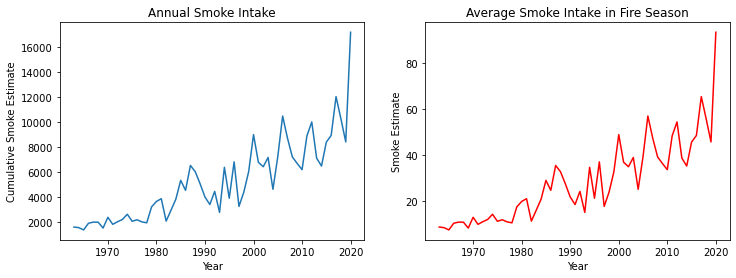

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 
# plot total smoke intake
axes[0].plot(smoke_estimates['Fire_Year'], smoke_estimates['annual_smoke_intake'])
axes[0].set_title('Annual Smoke Intake')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Cumulative Smoke Estimate')
# Plot estimate of daily average over the years
axes[1].plot(smoke_estimates['Fire_Year'], smoke_estimates['daily_avg_fire_szn'], color = 'r')
axes[1].set_title('Average Smoke Intake in Fire Season')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Smoke Estimate')

## 3. Comparing Estimate with AQI Data
---

### Data Collection

AQI data was collected from the US Environmental Protection Agency (EPA) Air Quality Service (AQS) API, which is a historical API and does not provide real-time air quality data. Specifically, we used the maximal daily average sensor data for monitoring stations in Deschutes County, all of which were <17 miles from Redmond, OR. These daily max values were then averaged for the fire season to get the annual estimate for 1983-2023. A detailed walkthrough of the data collection process can be found in [`./analysis_part1-AQI.ipynb`](./analysis_part1-AQI.ipynb)

The final data can be found as [`./output/final_annual_AQI_1983-2023.csv`](./output/final_annual_AQI_1983-2023.csv).

In [97]:
# Let's read in the relevant data sets
annual_aqi = pd.read_csv("./output/final_annual_AQI_1983-2023.csv", index_col=0)
smoke_estimates = pd.read_csv('./output/redmond_smoke_estimates.csv',index_col=0)

To see whether our estimate holds any value, we'll plot our smoke estimate's daily average smoke intake during the fire season (`smoke_estimates.daily_avg_fire_szn`) and the city's annual AQI (`annual_aqi.aqi`) an see if there is some linear relation between the two.

In [113]:
combined_estimate = smoke_estimates[['Fire_Year', 'daily_avg_fire_szn']].merge(
    annual_aqi, left_on='Fire_Year', right_on='year', how = 'left').rename(
        columns= {'daily_avg_fire_szn': 'smoke'}
)
combined_estimate = combined_estimate.drop(columns=['year'])

The R2 value is 0.18621276725785352 and Pearson correlation of 0.4315237736879088.
The p-value for the pearson test is 0.0068286630389915864


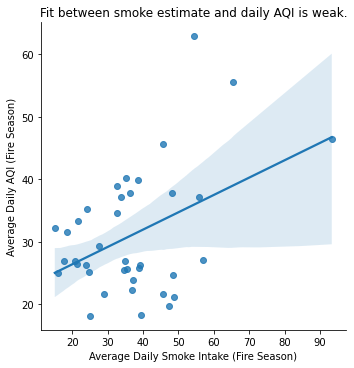

In [132]:
# Let's plot a simple linear regression using seaborn to show the 95% CI
sns.lmplot(x ='smoke', y ='aqi', data = combined_estimate, order= 1)
plt.xlabel("Average Daily Smoke Intake (Fire Season)")
plt.ylabel("Average Daily AQI (Fire Season)")
plt.title("Fit between smoke estimate and daily AQI is weak.")

# Get r2 & p-value for a Pearson Correlation Coefficient
r, p = sp.stats.pearsonr(combined_estimate.dropna()['smoke'], combined_estimate.dropna()['aqi'])
print(f"The R2 value is {r**2} and Pearson correlation of {r}.")
print(f"The p-value for the pearson test is {p}")

Off the bat, there doesn't seem to be a string linear link between my annual smoke estimate and the annual AQI estimates. The Pearson correlation coefficient is $0.43$, indicating a [moderate positive correlation](https://www.scribbr.com/statistics/correlation-coefficient/#types-of-correlation-coefficients) & the p-value is greater than our assumed significance level of 0.05. Interesting... there might be a significant correlation. Let's verify our assumptions of a [Pearson Coefficient Test](https://www.scribbr.com/statistics/pearson-correlation-coefficient/):
* Data are quantitative (True)
* Variables are normally distributed (?)
* Data have no outliers (potentially one at x= 90 and y=45)
* There is a lnear relationship between the two variables (ehh.. good enough)

Let's check the assumptions of normality by plotting the distribution of each estimate.

Text(0.5, 1.0, 'Annual smoke estimate does not follow a normal distribution.')

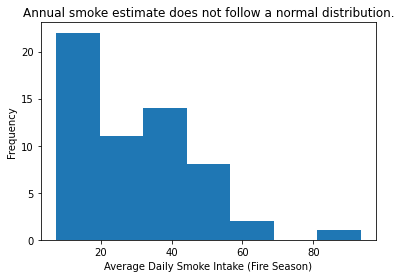

In [140]:
# Smoke Estimate
_ = plt.hist(combined_estimate['smoke'], bins = 7)
plt.xlabel("Average Daily Smoke Intake (Fire Season)")
plt.ylabel("Frequency")
plt.title("Annual smoke estimate does not follow a normal distribution.")

Text(0.5, 1.0, 'Annual AQI does not follow a normal distribution.')

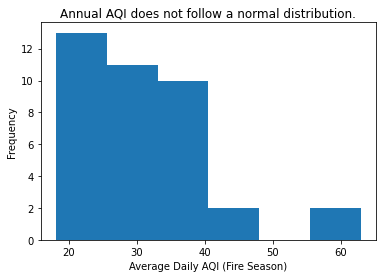

In [142]:
# AQI estimate
_ = plt.hist(combined_estimate['aqi'], bins=6)
plt.xlabel("Average Daily AQI (Fire Season)")
plt.ylabel("Frequency")
plt.title("Annual AQI does not follow a normal distribution.")

Clearly, our normality assumption doesn't hold true. This potentially confounded based on sample size of 38 years but also inherent in the problem -- we generally expect rarer air quality days and more frequent "good air" days so the distribution is bound to be long-tailed to the right.

So, let's instead use the [Spearman's rank correlation test](https://www.scribbr.com/statistics/correlation-coefficient/#spearmans-rho) which is more robust and doesn't require as many assumptions.

In [133]:
r, p = sp.stats.spearmanr(combined_estimate.dropna()['smoke'], combined_estimate.dropna()['aqi'])
print(f"The R2 value is {r**2} and Spearman rank correlation of {r}.")
print(f"The p-value for the Spearman rank test is {p}")

The R2 value is 0.022570631994673556 and Spearman rank correlation of 0.1502352554984134.
The p-value for the Spearman rank test is 0.36796054625722663


This indicates little to no link between the smoke estimate and the AQI. In the future, we will need to go back and revise our smoke estimate.

## 4. Forecasting
---
In this step, we will use our potentially faulty smoke estimate to get a prediction of smoke estimates for every year until 2049. Specifically, this will be a time series forecasting model with only 1 dependent variable.

The best place to start would be to first check for stationarity & then exploring the family of [autoregressive models](https://towardsdatascience.com/time-series-models-d9266f8ac7b0), starting with the Autoregressive Integrated Moving Average (ARIMA) model as they've typically been the [gold standard](https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6) for time-series analysis.

In the future, we can explore adding other exogenous variables such as the # of fires, total area burned, and average distance of fire.

This will require the [statsmodels](https://www.statsmodels.org/stable/index.html) library to make use of their [autoregression](https://www.statsmodels.org/stable/examples/notebooks/generated/autoregressions.html) models.

Before we start, let's check for stationaity using the [Augmented Dickey-Fuller Test](https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6#:~:text=Augmented%20Dickey%E2%80%93Fuller%20Test) at a siginificance level of 0.05. 

Note that because I'm not familiar with time series forecasting, I'm following the code from Brendan Artley in his [article](https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6) provided under the [MIT Licence](https://github.com/brendanartley/Medium-Article-Code/blob/main/LICENSE).

In [160]:
from statsmodels.tsa.stattools import adfuller
# Run test
dftest = adfuller(combined_estimate['smoke'], autolag='AIC')
# Make output more visible
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  1.324780
p-value                         0.996744
#Lags Used                      5.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


It appears that the data is not stationary, meaning that we can't use the standard ARMA model (`ARIMA(p, d, q)` with `d=0`). Instead, we must differentiate to find the order required for stationarity & **integrate** back up to get predictions with AR**I**MA. Let's explore `ARIMA(p, d, q)`, where p is the order of autoregressive model, d is the degree of differencing (how many differentiations to reach stationarity, and q is the order of moving-average model.

So, let's try to find the optimal method of ARIMA using [`pmdarima`](https://pypi.org/project/pmdarima/) which returns the best possible model from a search space using a consolidated hyperparmeter tuning based on AIC, or BIC. This package uses `statsmodels` on the backend but relates the interface in a manner similar to `sklearn`, which I'm familiar with.

The documentation for the `Auto_Arima()` function can be found [here](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima) and [here](https://alkaline-ml.com/pmdarima/tips_and_tricks.html#tips-and-tricks).

In [162]:
import pmdarima as pm

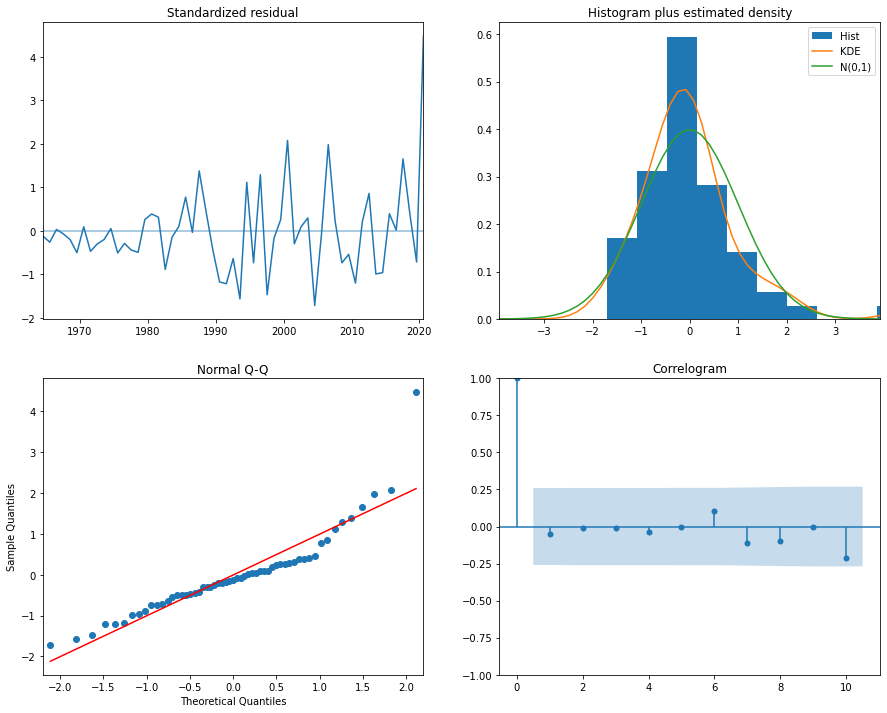

Wall time: 1.85 s


In [229]:
%%time
# Set index to be the middle of each fire season (August 1st)
combined_estimate.index = pd.to_datetime(combined_estimate['Fire_Year'], format = "%Y") + pd.DateOffset(months=7)

# Run tuning for ARIMA model
ARIMA_model = pm.auto_arima(combined_estimate['smoke'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use augmented Dickey- Fuller test to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1, # annual data has frequency of 1
                      d=None,# let model determine 'd'
                      seasonal=False, 
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

# plot diagnostics
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

These plots shows that this doesn't seem to be a great fit but it's not bad either. We'd expect the residuals to have no patterns and generally follow a N(0,1) distribution. Additionally, we expect no autocorrelation between lag values (the correlogram should have lag correlations within the desirable zone).

The residuals seem to slightl increase as time goes on (mainly at 2000 and at 2020) and it is slightly off from a normal distribution (mainly due to 2020). However, the lag correlations aren't significant.

Let's predict using our ARIMA model.

In [231]:
def forecast(ARIMA_model, periods=24):
    """""
    Generate a forecast using an ARIMA or SARIMA model and visualize the results.
    This function was developed by Brendan Artley under a MIT License.
    
    Specifically, we'll use yearly periods
    
    Parameters:
        ARIMA_model (ARIMA): A fitted ARIMA or SARIMA model.
        periods (int): Number of periods to forecast into the future.

    Returns:
    None
    """
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
#     index_of_fc = pd.date_range(
#         combined_estimate.index[-1] + pd.DateOffset(years=1), periods = n_periods, freq='Y')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted)
    lower_series = pd.Series(confint[:, 0], index=fitted_series.index)
    upper_series = pd.Series(confint[:, 1], index=fitted_series.index)

    # Plot
    fig = plt.figure(figsize=(10,5))
    plt.plot(combined_estimate["smoke"], color='#1f76b4', label = 'Original Data')
    plt.plot(fitted_series, color='darkgreen', label = "Predicted")
    plt.xlabel("Year")
    plt.ylabel("Average Daily Smoke Intake (Fire Season)")
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15 , label = "95% Confidence Interval")
    plt.legend(loc="upper left")
    return fig

Text(0.5, 1.0, 'ARIMA Forecast of Annual Smoke Estimate (Redmond, OR)')

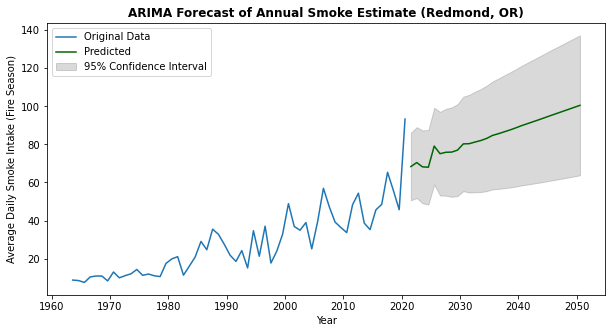

In [237]:
fig = forecast(ARIMA_model, periods = 2050-2020)
fig.gca().set_title("ARIMA Forecast of Annual Smoke Estimate (Redmond, OR)", weight='bold')

It's actually not bad! The increasing trend is captured but it can't seem to completely grasp the seemingly 3-5 year periodicity of peaks in the smoke estimate.

## 5. Visual Analysis
---

### 1. Histogram showing the number of fires occurring every 50 mile distance from Redmond, OR.



We can plot a simple histogram and set the bins to increment every 50 miles.

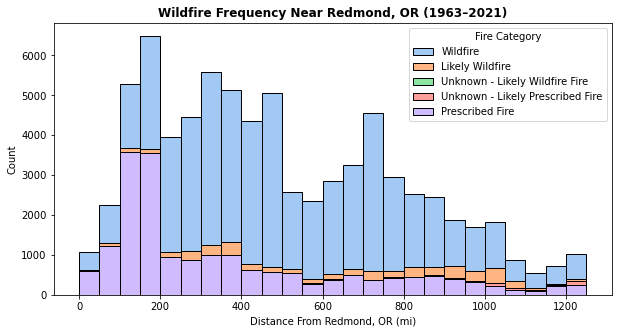

In [282]:
# Histogram by fire type
sns.set_palette('pastel')
fig = plt.figure(figsize=(10,5))
sns.histplot(data = redmond_subset, x='min_distance_city', hue='Assigned_Fire_Type',
    bins=range(0, 1250+1, 50), edgecolor='k', ax=fig.gca(), alpha=1, multiple='stack',
    hue_order=[
        "Wildfire",
        'Likely Wildfire',
        'Unknown - Likely Wildfire Fire',
        'Unknown - Likely Prescribed Fire',
        'Prescribed Fire']
)
# X label
plt.xlabel("Distance From Redmond, OR (mi)")
# Title
plt.title("Wildfire Frequency Near Redmond, OR (1963–2021)", weight='bold')
ax = fig.gca()
leg = ax.get_legend()
leg.set_title("Fire Category")
fig.savefig("./output/figure1-fires_freq_by_distance.png")

In [284]:
# get counts for each fire type
redmond_subset['Assigned_Fire_Type'].value_counts()

Wildfire                            52305
Prescribed Fire                     18995
Likely Wildfire                      3978
Unknown - Likely Prescribed Fire      451
Unknown - Likely Wildfire              90
Name: Assigned_Fire_Type, dtype: int64

### 2. Time series graph of total acres burned per year for the fires occurring within 1250 miles of Redmond, OR.


We can groupby the year and take the sum of all acres burned using `GIS_Acres`.

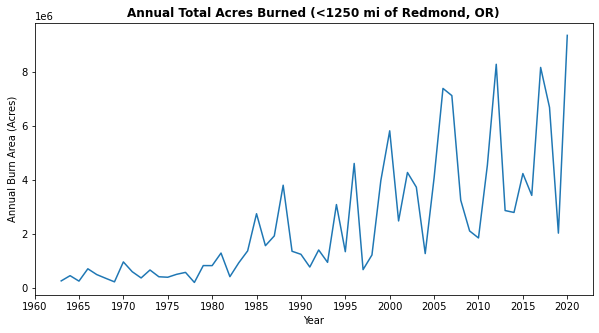

In [296]:
# time series of burn frequency
sns.set_palette("tab10")
fig = plt.figure(figsize=(10,5))
graph2 = redmond_subset[['Fire_Year', 'GIS_Acres']].groupby(by = 'Fire_Year').sum().reset_index()
sns.lineplot(x= 'Fire_Year', y='GIS_Acres', data=graph2)
ax = fig.gca()
# ax.set_xlim(1962, 2023)
ax.set_xticks(np.arange(1960, 2023, 5))
plt.xlabel("Year")
plt.ylabel("Annual Burn Area (Acres)")
plt.title("Annual Total Acres Burned (<1250 mi of Redmond, OR)", weight='bold')
fig.savefig("./output/figure2-annual_burn_over_time.png")

In [310]:
# get worst 6 years
graph2.sort_values(by='GIS_Acres', ascending=False).head(6)

,Fire_Year,GIS_Acres
57,2020,9.370603e+06
49,2012,8.295786e+06
54,2017,8.178597e+06
43,2006,7.399120e+06
44,2007,7.131949e+06
55,2018,6.694797e+06


### 3. Time series graph containing fire smoke estimate and the AQI estimate for Redmond, OR.


These values might initially be in different ranges and definitely have different units. As such, it  would make sense to have a [dual-axis plot](https://inforiver.com/insights/dual-axis-charts-101-introduction-best-practices/).

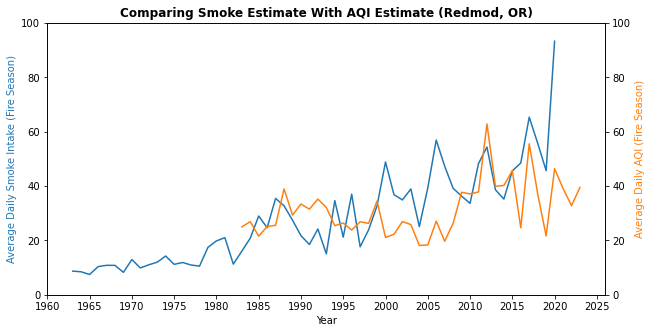

In [301]:
# We plot a dual-axis plot since both lines correspond to different values 
fig = plt.figure(figsize=(10, 5))
# plot smoke estimate
ax = sns.lineplot(data=combined_estimate, x='Fire_Year', y='smoke', 
                  color = sns.color_palette('tab10')[0])
ax2 = ax.twinx()
# plot aqi
sns.lineplot(data=annual_aqi, x='year', y='aqi',
             color=sns.color_palette('tab10')[1],
             ax=ax2)
ax.set_xlabel('Year')
ax.set_ylabel('Average Daily Smoke Intake (Fire Season)',
              color=sns.color_palette('tab10')[0])
ax2.set_ylabel('Average Daily AQI (Fire Season)',
               color=sns.color_palette('tab10')[1])
plt.title('Comparing Smoke Estimate With AQI Estimate (Redmod, OR)', weight='bold')

# set limits to the same value if desired 
_ = ax.set_yticks(ax.get_yticks())
_ = ax2.set_yticks(ax.get_yticks())

ax.set_xticks(np.arange(1960, 2026, 5))
fig.savefig("./output/figure3-comparing_smoke_AQI.png")